# Image Classification and Transfer Learning

This notebook is mostly a cut and paste of:

1. [Keras Image Classiciation Example](https://keras.io/examples/vision/image_classification_from_scratch/)
1. [Keras Transfer Learning Example](https://keras.io/examples/vision/keypoint_detection/)
1. [Keras Transfer Learning Documentation](https://keras.io/guides/transfer_learning/)

## Plan

The plan for today is to setup a image classification scenario where there are insufficient examples in the training set, necessitating the use of Transfer Learning.

## Image Classification Example

This section is basically a cut and paste of the [Keras Image Classiciation Example](https://keras.io/examples/vision/image_classification_from_scratch/), so I won't copy and paste the text also. We will follow the example from the Keras page.

Differences are:
* To "simulate" the cirmumstance of small training sample, we'll delete all but 1000 images of each class.
* We will only train a few epochs to demonstrate it's not doing well.
* We use a slightly larger image size (for compatibility with more models for transfer learning).


In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


/Users/afarbin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


We are downloading the data here. Note that it's commented out because we only need to do this once.

In [2]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

We also only need to unzip once.

In [3]:
#!unzip -q kagglecatsanddogs_5340.zip
!ls

CDLA-Permissive-2.0.pdf
Image Classification and Transfer Learning.ipynb
PetImages
kagglecatsanddogs_5340.zip
readme[1].txt
save_at_1.keras
save_at_10.keras
save_at_11.keras
save_at_12.keras
save_at_13.keras
save_at_14.keras
save_at_15.keras
save_at_16.keras
save_at_17.keras
save_at_18.keras
save_at_19.keras
save_at_2.keras
save_at_20.keras
save_at_3.keras
save_at_4.keras
save_at_5.keras
save_at_6.keras
save_at_7.keras
save_at_8.keras
save_at_9.keras


In [4]:
!ls PetImages

Cat Dog


And we only need to delete the extra images only once.

In [5]:
#  num_skipped = 0
# for folder_name in ("Cat", "Dog"):
#     max_images = 100
#     folder_path = os.path.join("PetImages", folder_name)
#     for image_i,fname in enumerate(os.listdir(folder_path)):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = b"JFIF" in fobj.peek(10)
#         finally:
#             fobj.close()

#         if image_i > max_images or not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print(f"Deleted {num_skipped} images.")

Note the image size change:

In [6]:
#image_size = (180, 180)
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 202 files belonging to 2 classes.
Using 162 files for training.
Using 40 files for validation.


2024-04-12 08:06:07.422552: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-12 08:06:07.422589: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 08:06:07.422593: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 08:06:07.422633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 08:06:07.422649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


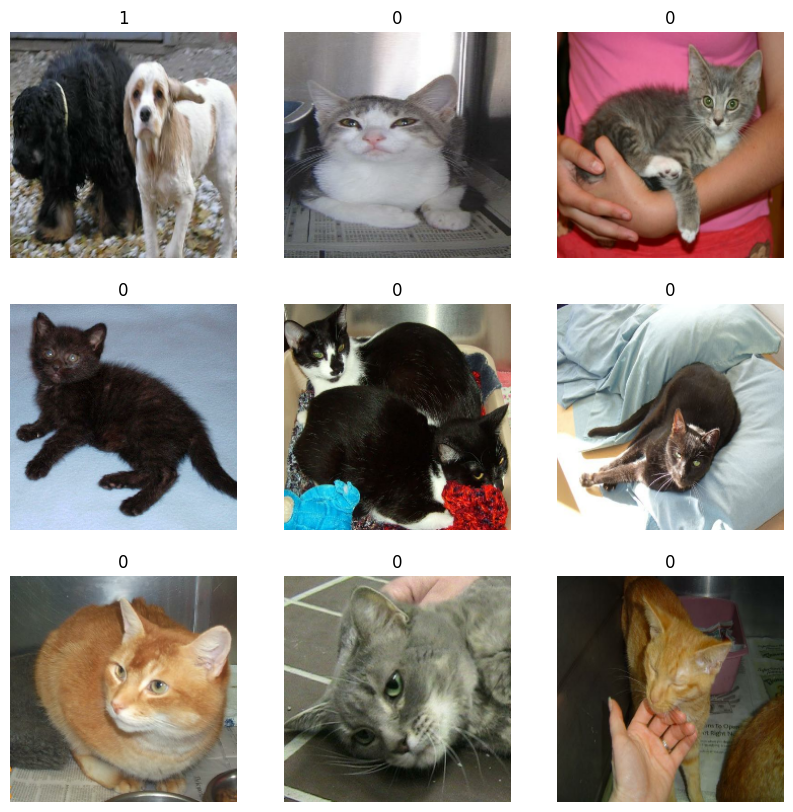

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

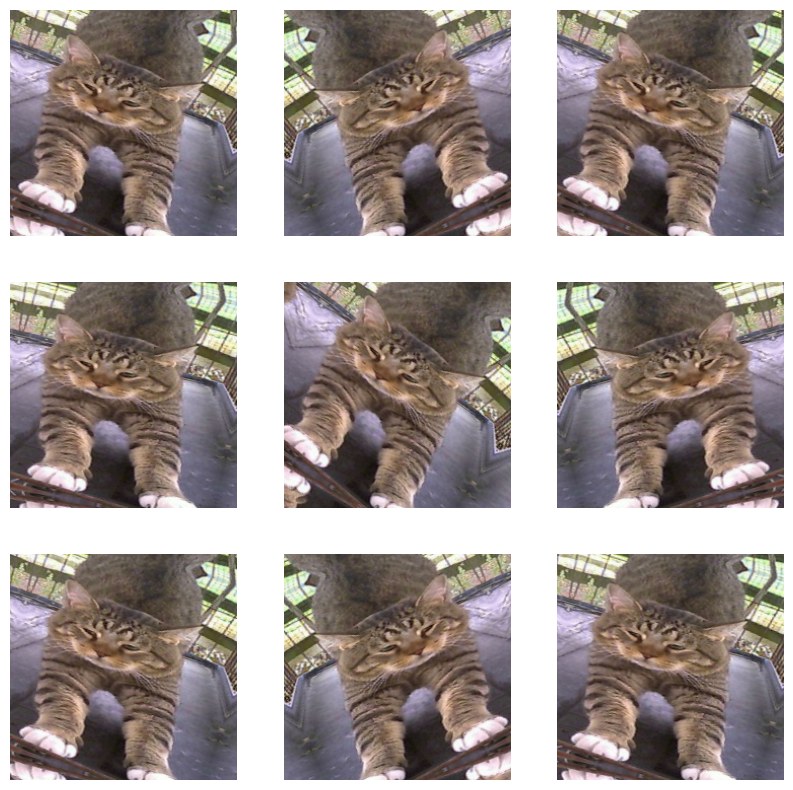

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [12]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8


2024-04-12 08:06:09.168049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 11s 612ms/step - loss: 0.6728 - acc: 0.6358 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/8
17/17 [==============================] - 10s 590ms/step - loss: 0.5770 - acc: 0.6975 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 3/8
17/17 [==============================] - 10s 581ms/step - loss: 0.5646 - acc: 0.6790 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/8
17/17 [==============================] - 10s 580ms/step - loss: 0.5229 - acc: 0.7346 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 5/8
17/17 [==============================] - 10s 574ms/step - loss: 0.5344 - acc: 0.7222 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 6/8
17/17 [==============================] - 10s 574ms/step - loss: 0.5175 - acc: 0.7469 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 7/8
17/17 [==============================] - 10s 584ms/step - loss: 0.4513 - acc: 0.7469 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 8/8
17/17 [==============================] - 10s 573ms/step - loss: 0.4454 - acc

As you can see, the model doesn't perform very well on this small dataset. It also takes a very long time to go through the data on this laptop without a GPU.

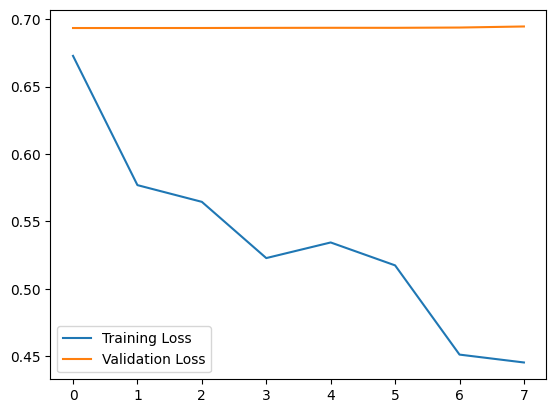

In [13]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

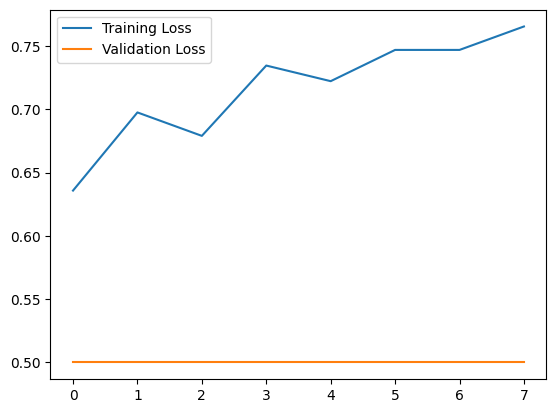

In [14]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

## Transfer Learning

Now we will follow [Keras Transfer Learning Example](https://keras.io/examples/vision/keypoint_detection/), which is setup for a different task (object detection).

Differences from that example:
* Using the same cat/dog dataset as before.
* Changing task from object detection to classification, using exactly the same final layers as the model above.
* Wrapping things in functions that mirror what we did above.

In [16]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [17]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [18]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
17/17 [==============================] - 3s 120ms/step - loss: 0.7274 - acc: 0.5802 - val_loss: 0.6163 - val_acc: 0.6250
Epoch 2/8
17/17 [==============================] - 1s 78ms/step - loss: 0.5603 - acc: 0.6914 - val_loss: 0.4666 - val_acc: 0.7000
Epoch 3/8
17/17 [==============================] - 1s 78ms/step - loss: 0.4348 - acc: 0.7654 - val_loss: 0.3623 - val_acc: 0.9250
Epoch 4/8
17/17 [==============================] - 1s 79ms/step - loss: 0.3421 - acc: 0.8580 - val_loss: 0.2894 - val_acc: 0.9750
Epoch 5/8
17/17 [==============================] - 1s 81ms/step - loss: 0.2665 - acc: 0.9259 - val_loss: 0.2393 - val_acc: 0.9750
Epoch 6/8
17/17 [==============================] - 1s 83ms/step - loss: 0.2629 - acc: 0.9012 - val_loss: 0.2039 - val_acc: 0.9750
Epoch 7/8
17/17 [==============================] - 1s 83ms/step - loss: 0.2118 - acc: 0.9198 - val_loss: 0.1775 - val_acc: 0.9750
Epoch 8/8
17/17 [==============================] - 2s 88ms/step - loss: 0.1833 - acc: 0.9

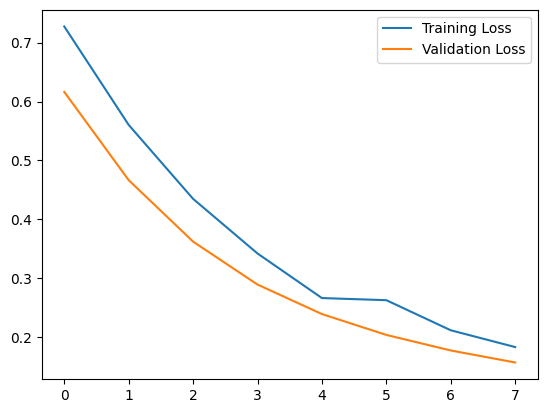

In [19]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

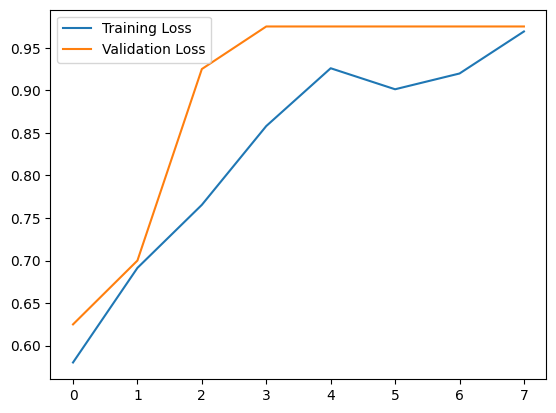

In [20]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

## Computer Vision Homework

* Select an image classification dataset of your choice. 
    * Images should be at least 100x100 size.
    * Image datasets are can be very large and we are going to only use a relatively subset.
        * Select Datasets that are either:
            * Reasonable size 
                * You can download in reasonable time 
                * Small enough to not take too much space on your computer
            * Allow you to download a subset.
    * Some example datasets:
        * [Big list from Kaggle](https://www.kaggle.com/datasets?search=image)
        * [Images of buildings, forest, glacier, mountain, sea, street](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
        * [Indoor Scenes](https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019/data)
        * [Concrete Cracks](https://data.mendeley.com/datasets/5y9wdsg2zt/2)
        * [Architectural Elements](https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset)
        * [Fruits](https://www.kaggle.com/datasets/moltean/fruits)
        * [Scene Understanding](https://www.tensorflow.org/datasets/catalog/sun397)
        * [blood-cells](https://www.kaggle.com/datasets/paultimothymooney/blood-cells)
        * [Cellular Recursion](https://www.kaggle.com/datasets/xhlulu/recursion-cellular-image-classification-224-jpg)
* Create a new notebook for working out the data loader and augmentation (`DataLoader.ipynb`).
    * Follow the Keras examples and this notebook.
    * Setup the dataset for a demonstration of transfer learning
        * Perform any cleaning necessary, like throwing out bad images. 
            * This will be specific to your dataset. 
            * You may discover a problem later, come back and eliminate the bad images here.
        * Select at most 5 classes. Discard the rest of the data.
        * Create a smaller subset of less 100 images per class for training and testing.
        * Figure out how the labels are provided and create a data loader to load the data.
            * If the images are separated into subdirectories, the example above works.
            * If the image information is in a CSV file, easist path is to figure out the way to separate your classes into subdirectories and use the above example.
    * Visualize the images, making sure the data loader is working properly.
    * Create a module which holds the data loader and any other code you may need to reuse.
* Create a new notebook to train a baseline model (`TrainBaseModel.ipynb`)
    * Implement and train a transfer learning model, selecting a model from [Keras Built-in Vision Models](https://keras.io/api/applications/)
    * Make sure you look make the learning curves.
    * Save the model using `model.save()` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
* Create a new notebook to see effect of data augmentation a baseline model (`TrainBaseModelAugmentation.ipynb`):
    * Add data augmentation.
        * Select at least 3 augmentations that make sense for your datasets (see [Keras Image Augmentation Layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)).
        * Visualize the data augmentation to make sure it's working as expected.
    * Train the same model now with data augmentation.
    * Save the new model.   
    * Test if data augmentation is helping:
        * Create a new notebook (`CompareAugmentation.ipynb`)
        * Load the 2 models and compare the ROC curves with and without augmentation.
* Train the three different transfer learning models (`Train-XXXX.ipynb`):
    * Select 2 additional models from [Keras Built-in Vision Models](https://keras.io/api/applications/).
    * Create a new notebook for the each model.
        * Implement and train the model.
        * Make sure you look make the learning curves.
        * Save the model using `model.save` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
    * Copy the notebook and try a different base model.
* Compare the three models:
    * Create a new notebook (`CompareModels.ipynb`)
    * Load the 3 models.
    * Make a plot comparing the 3 ROC curves of the 3 models on the validation dataset.
